In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
from pandas import DataFrame
import urllib.parse
import datetime as dt


In [2]:
def get_playercount(appid: int = 730) -> dict:
    """
    Extracts current playercount from Steam API and 24-hour and all-time peak from steamcharts.com

    Parameters:
        appid (int): Steam appid. Defaults to 730 (CS:GO)
    Returns:
        dict: A dictionary with the current playercount, 24-hour peak and all-time peak
    """
    page = requests.get(
        f'https://steamcharts.com/app/{appid}')
    soup = BeautifulSoup(page.content, 'lxml')
    tag = soup.find('div', id='app-heading')
    tags = tag.find_all('div', class_="app-stat")
    result = {}
    result['24-hour peak'] = int(tags[1].find('span').string)
    result['All-time peak'] = int(tags[2].find('span').string)
    response = requests.get(
        f'https://api.steampowered.com/ISteamUserStats/GetNumberOfCurrentPlayers/v1/?appid={appid}')
    result['Playercount'] = response.json().get(
        'response', {}).get('player_count', 0)
    return result


In [3]:
get_playercount()


{'24-hour peak': 1473459, 'All-time peak': 1519457, 'Playercount': 1035581}

In [4]:
def get_unboxing_numbers() -> DataFrame:
    """
    Extracts unboxing numbers from csgocasetracker.com

    Returns:
        DataFrame: A dataframe with total, monthly, weekly and daily unboxing number for every case
    """
    daily_response = requests.get(
        'https://csgocasetracker.com/calculations/calcDaily.csv')
    daily_csv = StringIO(daily_response.content.decode('utf-8'))
    weekly_response = requests.get(
        'https://csgocasetracker.com/calculations/calcWeekly.csv')
    weekly_csv = StringIO(weekly_response.content.decode('utf-8'))
    monthly_response = requests.get(
        'https://csgocasetracker.com/calculations/calculation.csv')
    monthly_csv = StringIO(monthly_response.content.decode('utf-8'))
    total_response = requests.get(
        'https://csgocasetracker.com/calculations/calculationTotal.csv')
    total_csv = StringIO(total_response.content.decode('utf-8'))
    daily_df = pd.read_csv(daily_csv, sep=',')
    weekly_df = pd.read_csv(weekly_csv, sep=',')
    monthly_df = pd.read_csv(monthly_csv, sep=',')
    total_df = pd.read_csv(total_csv, sep=',')
    result = pd.DataFrame()
    result['Case Name'] = total_df['Case Name']
    result['Total Unboxing Number'] = total_df['Unboxing Number']
    result['Monthly Unboxing Number'] = monthly_df['Unboxing Number']
    result['Weekly Unboxing Number'] = weekly_df['Unboxing Number']
    result['Daily Unboxing Number'] = daily_df['Unboxing Number']
    return result


In [5]:
get_unboxing_numbers()


,Case Name,Total Unboxing Number,Monthly Unboxing Number,Weekly Unboxing Number,Daily Unboxing Number
0,CS:GO Weapon Case,4620615,24769,4769,923
1,eSports 2013 Case,3055846,10615,1692,615
2,Operation Bravo Case,3682258,11963,2392,0
3,CS:GO Weapon Case 2,4166524,31339,6267,1566
4,eSports 2013 Winter Case,7634188,30294,6267,1044
5,Winter Offensive Weapon Case,14030326,59753,15724,3931
6,CS:GO Weapon Case 3,4003561,23504,4700,1566
7,Operation Phoenix Weapon Case,54673974,506520,158760,22680
8,Huntsman Weapon Case,23750807,64349,20474,2924
9,Operation Breakout Weapon Case,59950859,461160,151200,45360


In [6]:
def get_price_history(item_name: str) -> DataFrame:
    """
    Extracts price history for an item from Steam

    Returns:
        DataFrame: A dataframe with price history containing datetimes, prices and amount sold for the given item
    """

    url = f"https://steamcommunity.com/market/listings/730/{urllib.parse.quote(item_name)}"
    response = requests.get(url).text
    response = response[response.find("line1")+6:]
    response = response[0:response.find("]];")+2]

    price_list = eval(response)
    month_list = [None,
                  'Jan',
                  'Feb',
                  'Mar',
                  'Apr',
                  'May',
                  'Jun',
                  'Jul',
                  'Aug',
                  'Sep',
                  'Oct',
                  'Nov',
                  'Dec']
    for i, entry in enumerate(price_list):
        # Date and time
        date_time = entry[0]
        date_time = date_time.split(" ")
        month = month_list.index(date_time[0])
        day = int(date_time[1])
        year = int(date_time[2])
        hour = int(date_time[3].split(":")[0])
        date_time = dt.datetime(
            year, month, day, hour=hour, minute=0, second=0)

        # Price
        price = float(entry[1])

        # Amount sold
        sold = int(entry[2])

        # compile dictionary and add it back to the list
        price_dict = {
            "Date": date_time,
            "Price(USD)": price,
            "Amount sold": sold
        }
        price_list[i] = price_dict

    df = pd.DataFrame.from_dict(price_list)

    return df


In [7]:
price_history = get_price_history('Dreams & Nightmares Case')
price_history


,Date,Price(USD),Amount sold
0,2022-01-21 01:00:00,10.675,76680
1,2022-01-22 01:00:00,6.173,70330
2,2022-01-23 01:00:00,4.914,62767
3,2022-01-24 01:00:00,4.328,52950
4,2022-01-25 01:00:00,3.996,51942
...,...,...,...
1156,2023-04-15 04:00:00,2.000,5078
1157,2023-04-15 05:00:00,1.994,5590
1158,2023-04-15 06:00:00,2.030,4978
1159,2023-04-15 07:00:00,1.972,3910


<AxesSubplot:xlabel='Date'>

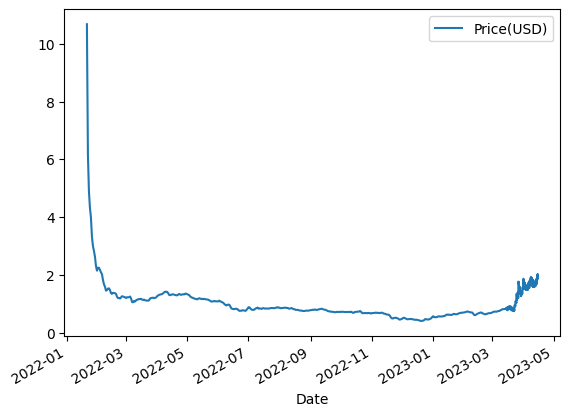

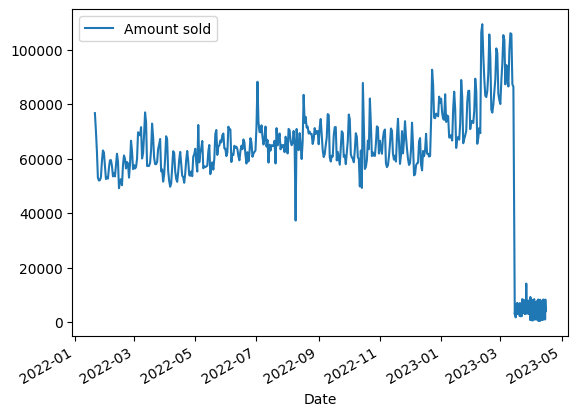

In [8]:
price_history.plot(x='Date', y='Price(USD)', rot=30)
price_history.plot(x='Date', y='Amount sold', rot=30)


In [9]:
def smoothen_price_history(df: DataFrame) -> DataFrame:
    """
    Aggregates hourly values for the past month into daily values so that time gaps between all values are consistent

    Parameters:
        DataFrame: A dataframe with price history acquired from price_history()
    Returns:
        DataFrame: A dataframe with price history with average daily prices and total daily amounts sold for the last month
    """
    df_copy = df.copy()
    df_copy['Date'] = df_copy['Date'].apply(lambda x: x.date())
    df_copy = df_copy.groupby('Date', as_index=False).agg(
        {'Price(USD)': 'mean', 'Amount sold': 'sum'})
    return df_copy


In [10]:
smooth_price_history = smoothen_price_history(price_history)
smooth_price_history


,Date,Price(USD),Amount sold
0,2022-01-21,10.675000,76680
1,2022-01-22,6.173000,70330
2,2022-01-23,4.914000,62767
3,2022-01-24,4.328000,52950
4,2022-01-25,3.996000,51942
...,...,...,...
445,2023-04-11,1.673167,106680
446,2023-04-12,1.691375,104462
447,2023-04-13,1.749208,104666
448,2023-04-14,1.860542,115048


<AxesSubplot:xlabel='Date'>

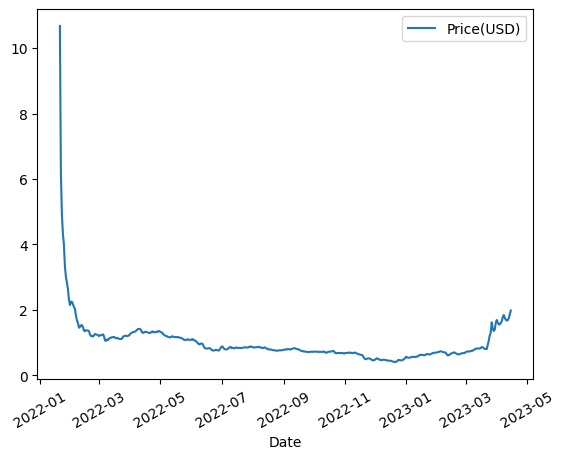

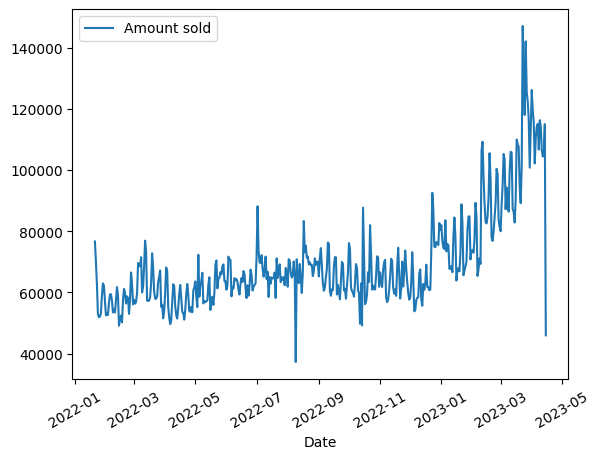

In [11]:
smooth_price_history.plot(x='Date', y='Price(USD)', rot=30)
smooth_price_history.plot(x='Date', y='Amount sold', rot=30)


In [12]:
def get_smooth_price_history(item_name: str) -> DataFrame:
    """
    Extracts price history for an item from Steam with values from the last month aggregated to have daily instead of hourly data

    Returns:
        DataFrame: A dataframe with price history containing dates, prices and amount sold for the given item
    """
    return smoothen_price_history(get_price_history(item_name))


In [13]:
smooth_price_history2 = get_smooth_price_history('Recoil Case')
smooth_price_history2


,Date,Price(USD),Amount sold
0,2022-07-01,18.725000,6647
1,2022-07-02,9.067000,65281
2,2022-07-03,6.088000,55152
3,2022-07-04,4.924000,50299
4,2022-07-05,4.465000,51490
...,...,...,...
284,2023-04-11,1.255667,87075
285,2023-04-12,1.259167,84900
286,2023-04-13,1.274917,85077
287,2023-04-14,1.340458,81461


<AxesSubplot:xlabel='Date'>

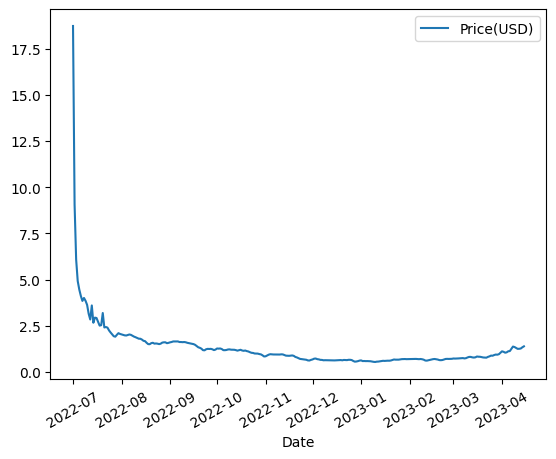

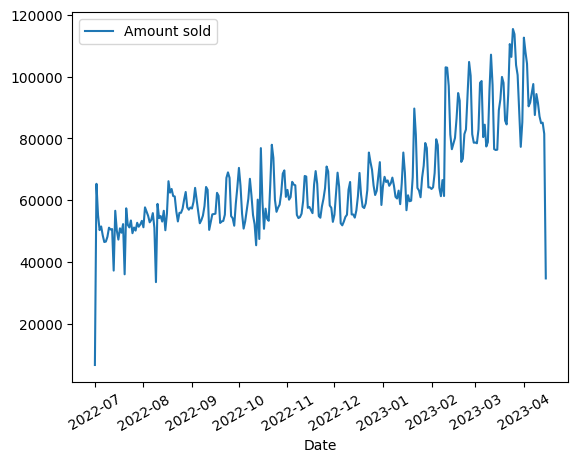

In [14]:
smooth_price_history2.plot(x='Date', y='Price(USD)', rot=30)

smooth_price_history2.plot(x='Date', y='Amount sold', rot=30)


In [15]:
def get_historical_monthly_unboxing_numbers() -> DataFrame:
    """
    Extracts historical monthly unboxing numbers from csgocasetracker.com

    Returns:
        DataFrame: A dataframe with historical monthly unboxing numbers for every case
    """
    # Extracting stats
    csv_ids = ['january2022', 'february2022', 'march2022', 'april2022', 'may2022', 'june2022',
               'july2022', 'august2022', 'september2022', 'october2022', 'november2022',
               'december2022', 'january2023', 'february2023', 'march2023']
    df_list = []
    for id in csv_ids:
        response = requests.get(
            f'https://csgocasetracker.com/calculations/previousCalc/{id}.csv')
        csv = StringIO(response.content.decode('utf-8'))
        df = pd.read_csv(csv, sep=',')
        df_list.append(df)

    # Add a new column 'Month' in each dataframe to represent the month based on its position in the list
    for i, df in enumerate(df_list):
        df['Month'] = i + 1

    # Drop useless columns and merge the data
    df_list = [df[['Month', 'Case Name', 'Unboxing Number']] for df in df_list]
    df_concatenated = pd.concat(df_list)
    df_pivoted = df_concatenated.pivot(
        index='Case Name', columns='Month', values='Unboxing Number')
    df_pivoted.reset_index(inplace=True)

    # Make the cases to go in original order instead of alphabetical order
    case_names_order = df_list[-1]['Case Name'].values
    df_pivoted = df_pivoted.sort_values(by='Case Name', key=lambda x: x.map(
        {case: i for i, case in enumerate(case_names_order)}))

    df_pivoted.reset_index(drop=True, inplace=True)
    df_pivoted.fillna(0, inplace=True)
    df_transposed = df_pivoted.set_index('Case Name').transpose()
    df_transposed.index.name = None

    # Add a 'Month' column with month and year values as dates
    start_month = dt.date(2022, 1, 1)
    df_transposed['Month'] = [start_month +
                              pd.DateOffset(months=i) for i in range(len(df_transposed))]

    # Move the 'Month' column to be the first column in the dataframe
    cols = df_transposed.columns.tolist()
    cols = ['Month'] + cols[:-1]
    df_transposed = df_transposed[cols]

    return df_transposed


In [16]:
def montly_unboxing_numbers_to_daily(df: DataFrame) -> DataFrame:
    """
    Converts monthly historical unboxing numbers into daily numbers.

    Parameters:
        df(DataFrame): A dataframe with montly unboxing numbers acquired from get_historical_monthly_unboxing_numbers()
    Returns:
        DataFrame: A dataframe with historical daily unboxing numbers
    """
    df_result = df.copy()

    df_result['Month'] = pd.to_datetime(df_result['Month'])

    # Set 'Month' column as the index to use days_in_month attribute
    df_result.set_index('Month', inplace=True)
    df_result['Days in Month'] = df_result.index.days_in_month

    # Rescale values
    for col in df_result.columns[:-1]:
        df_result[col] = df_result[col] / df_result['Days in Month']
    df_result.drop('Days in Month', axis=1, inplace=True)

    # Expand the values so there's data for every day of each month and not only for the first day
    # These four lines are here so that we do not exclude the last month when filling in values
    last_date = df_result.index[-1]
    last_row = df_result.iloc[-1]
    last_row.name = last_date + pd.offsets.MonthEnd(0)
    df_result = pd.concat([df_result, pd.DataFrame(
        [last_row], columns=df_result.columns)])

    df_result = df_result.resample('D').ffill()

    df_result.reset_index(inplace=True)
    df_result.rename(columns={'index': 'Date'}, inplace=True)
    return df_result


In [17]:
def unboxing_moving_average(df: DataFrame, n: int = 30) -> DataFrame:
    """
    Applies a moving average to daily unboxing numbers 

    Parameters:
        df(DataFrame): A dataframe with daily unboxing numbers acquired from montly_unboxing_numbers_to_daily()
        n(int): Amount of days for the moving average. Defaults to 30
    Returns:
        DataFrame: A dataframe with smoothed historical daily unboxing numbers
    """
    df_ma = df.copy()
    df_ma.set_index('Date', inplace=True)
    df_ma = df_ma.rolling(f'{n}D').mean()
    df_ma.reset_index(inplace=True)
    return df_ma


In [18]:
def get_historical_daily_unboxing_numbers(n: int = 30) -> DataFrame:
    """
    Extracts historical monthly unboxing numbers from csgocasetracker.com, rescales them to
    get daily numbers and applies a moving average if needed.

    Parameters:
        n(int): Amount of days for the moving average. Defaults to 30
    Returns:
        DataFrame: A dataframe with historical daily unboxing numbers for every case
    """
    df = get_historical_monthly_unboxing_numbers()
    df = montly_unboxing_numbers_to_daily(df)
    df = unboxing_moving_average(df, n)
    return df


In [19]:
get_historical_monthly_unboxing_numbers()


Case Name,Month,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
1,2022-01-01,23231.0,9846.0,19141.0,20370.0,26116.0,24373.0,6268.0,378000.0,64349.0,...,241920.0,104463.0,1525166.0,1967865.0,1259259.0,2051282.0,3063628.0,733143.0,0.0,0.0
2,2022-02-01,20923.0,6154.0,11963.0,9402.0,16714.0,22015.0,17236.0,219240.0,35100.0,...,226800.0,87369.0,1635328.0,2094649.0,1160494.0,2106363.0,2491928.0,1565052.0,0.0,0.0
3,2022-03-01,19846.0,9385.0,4785.0,12536.0,15670.0,25946.0,23504.0,309960.0,38025.0,...,340200.0,119658.0,1698006.0,2502893.0,1297246.0,2888889.0,2093067.0,2260209.0,0.0,0.0
4,2022-04-01,21077.0,6615.0,7178.0,14103.0,28205.0,28304.0,20370.0,347760.0,29250.0,...,241920.0,112061.0,1726496.0,2244841.0,1183286.0,2807217.0,1221273.0,2345679.0,0.0,0.0
5,2022-05-01,13846.0,5385.0,9571.0,10969.0,13580.0,35380.0,20370.0,272160.0,29250.0,...,173880.0,87369.0,1728395.0,2330318.0,1171890.0,2830009.0,850902.0,2184236.0,0.0,0.0
6,2022-06-01,17538.0,5231.0,11963.0,6268.0,27160.0,25946.0,25071.0,226800.0,23400.0,...,204120.0,79772.0,1530864.0,1893998.0,793922.0,2410256.0,493827.0,2351377.0,0.0,0.0
7,2022-07-01,15846.0,6154.0,7178.0,10969.0,13580.0,25159.0,14103.0,325080.0,64349.0,...,234360.0,96866.0,1726496.0,2487619.0,649573.0,2695157.0,450142.0,2763533.0,1518063.0,0.0
8,2022-08-01,17692.0,4154.0,9571.0,12536.0,9402.0,30663.0,10969.0,204120.0,29250.0,...,302400.0,72175.0,1582146.0,2692918.0,676163.0,2763533.0,402659.0,2723647.0,2044558.0,0.0
9,2022-09-01,14769.0,5538.0,9571.0,20370.0,18803.0,29091.0,14103.0,226800.0,35100.0,...,204120.0,83571.0,1460589.0,2327366.0,592593.0,2535613.0,385565.0,3012346.0,2380931.0,0.0
10,2022-10-01,15538.0,4462.0,4785.0,10969.0,12536.0,24373.0,6268.0,181440.0,29250.0,...,264600.0,70275.0,1061728.0,1991956.0,442545.0,2049383.0,260209.0,2693257.0,2082583.0,0.0


In [20]:
get_historical_daily_unboxing_numbers(n=30)


Case Name,Date,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
0,2022-01-01,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
1,2022-01-02,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
2,2022-01-03,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
3,2022-01-04,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
4,2022-01-05,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2023-03-27,767.847350,339.767972,450.936636,772.635599,893.932373,1615.664977,573.150000,13036.645161,1653.876498,...,13151.612903,2980.059447,68085.234217,129964.602995,14182.637097,119314.350576,7199.503111,167044.535023,139056.997811,81689.985945
451,2023-03-28,774.919739,347.264670,454.979263,784.671045,910.460292,1626.626114,567.433333,12999.483871,1668.702611,...,13238.709677,2987.426728,68835.704531,130700.638556,14172.790323,120429.663825,7229.991321,168138.840553,139881.697465,82909.162673
452,2023-03-29,781.992127,354.761367,459.021889,796.706490,926.988210,1637.587250,561.716667,12962.322581,1683.528725,...,13325.806452,2994.794009,69586.174846,131436.674117,14162.943548,121544.977074,7260.479531,169233.146083,140706.397120,84128.339401
453,2023-03-30,789.064516,362.258065,463.064516,808.741935,943.516129,1648.548387,556.000000,12925.161290,1698.354839,...,13412.903226,3002.161290,70336.645161,132172.709677,14153.096774,122660.290323,7290.967742,170327.451613,141531.096774,85347.516129


In [29]:
def update_with_recent_daily_numbers(df: DataFrame) -> DataFrame:
    """
    Updates historical daily unboxing numbers from csgocasetracker.com with recent values.

    Parameters:
        df(DataFrame): A dataframe with historical daily unboxing numbers for every case acquired from get_historical_daily_unboxing_numbers() or montly_unboxing_numbers_to_daily()
    Returns:
        DataFrame: A dataframe with historical daily unboxing numbers for every case up to today
    """

    df_expanded = df.copy()
    df_expanded.set_index('Date', inplace=True)

    # Expand the dataframe to include dates up to today
    last_date = df_expanded.index[-1]
    today = pd.Timestamp(dt.datetime.now().date())
    days_to_today = (today - last_date).days
    date_range = pd.date_range(last_date, periods=days_to_today + 1)
    df_expansion = df_expanded.reindex(date_range)
    df_expanded = pd.concat([df_expanded, df_expansion])

    # Fill in missing values
    df_recent = get_unboxing_numbers()
    for _, row in df_recent.iterrows():
        case_name = row['Case Name']

        last_month = df_expanded.index[-1] - pd.DateOffset(months=1)
        days_in_last_month = last_month.days_in_month
        monthly_unboxing = row['Monthly Unboxing Number'] / days_in_last_month
        weekly_unboxing = row['Weekly Unboxing Number'] / 7
        daily_unboxing = row['Daily Unboxing Number']

        df_expanded.loc[df_expanded.index[-1], case_name] = daily_unboxing
        df_expanded.loc[df_expanded.index[-7]:df_expanded.index[-1],
                        case_name] = df_expanded.loc[df_expanded.index[-7]:df_expanded.index[-1], case_name].fillna(weekly_unboxing)
        df_expanded.loc[last_month:, case_name] = df_expanded.loc[last_month:, case_name].fillna(
            monthly_unboxing)

    df_expanded.reset_index(inplace=True)
    df_expanded.rename(columns={'index': 'Date'}, inplace=True)

    return df_expanded


In [30]:
update_with_recent_daily_numbers(get_historical_daily_unboxing_numbers())


Case Name,Date,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
0,2022-01-01,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.0
1,2022-01-02,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.0
2,2022-01-03,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.0
3,2022-01-04,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.0
4,2022-01-05,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,2023-04-11,681.285714,241.714286,341.714286,895.285714,895.285714,2246.285714,671.428571,22680.000000,2924.857143,...,18360.000000,4341.285714,99308.000000,188631.000000,13838.000000,181250.714286,7597.285714,197802.142857,145830.857143,110704.0
467,2023-04-12,681.285714,241.714286,341.714286,895.285714,895.285714,2246.285714,671.428571,22680.000000,2924.857143,...,18360.000000,4341.285714,99308.000000,188631.000000,13838.000000,181250.714286,7597.285714,197802.142857,145830.857143,110704.0
468,2023-04-13,681.285714,241.714286,341.714286,895.285714,895.285714,2246.285714,671.428571,22680.000000,2924.857143,...,18360.000000,4341.285714,99308.000000,188631.000000,13838.000000,181250.714286,7597.285714,197802.142857,145830.857143,110704.0
469,2023-04-14,681.285714,241.714286,341.714286,895.285714,895.285714,2246.285714,671.428571,22680.000000,2924.857143,...,18360.000000,4341.285714,99308.000000,188631.000000,13838.000000,181250.714286,7597.285714,197802.142857,145830.857143,110704.0
